### Bayesian Data Analysis, 3rd ed
##  Chapter 3, demo 1-4

원저자:
- Aki Vehtari aki.vehtari@aalto.fi
- Tuomas Sivula tuomas.sivula@aalto.fi

2차저자:
- 민태규
- 문현지

평균과 분산이 알려지지 않는 경우의 정규분포 모형에 대한 예제를 다뤄봅니다. (BDA3 section 3.2 on p. 64).

In [36]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# scaled inverse chi-squared와 plot도구를 utilities로부터 import
import sinvchi2
import plot_tools

# plot 설정
plt.rc('font', size=12)
plt.style.use(plot_tools.custom_styles['gray_background'])

In [37]:
# 데이터
y = np.array([93, 112, 122, 135, 122, 150, 118, 90, 124, 114])

# 충분통계량(sufficient statistics)은 다음과 같다.
# n은 데이터의 크기 = 10
# s2는 표본분산
# my는 표본평균

n = len(y)
s2 = np.var(y, ddof=1)
my = np.mean(y)

#s2의 경우, 모분산이 아닌 표본분산을 구하기 위해 ddof=1로 지정했으며, ddof는 Delta Degrees of Freedom의 약자.

In [38]:
# 난수를 생성
rng = np.random.RandomState(seed=0)

In [39]:
# 결합분포 p(mu,sigma2|y)를 p(sigma2|y)p(mu|sigma2,y)로 분해 후 mu, sigma의 결합사후분포로부터 sampling

# p(sigma2|y)로부터 얻은 표본 (A)
sigma2 = sinvchi2.rvs(n-1, s2, size=1000, random_state=rng)

# p(mu|sigma2,y)로부터 얻은 표본 (B)
mu = my + np.sqrt(sigma2/n)*rng.randn(*sigma2.shape)

# sigma는 표준편차, sigma2는 분산
sigma = np.sqrt(sigma2)

# 각각의 (mu, sigma)에 대해 예측분포 p(ynew|y)로부터 얻은 표본 (C)
ynew = rng.randn(*mu.shape)*sigma + mu

정리하면

(A) p(sigma2|y)에서 sigma 추출

(B) p(mu|sigma2,y)에서 mu 추출

(C) p(mu,sigma2|y)에서 추출한 mu, sigma를 결합해 ynew 추출, p(mu,sigma2|y)은  

샘플(데이터, 여기선 y)들의 통계량만을 이용하는 모수추정과 전체 샘플을 이용하는 모수추정이 동일한 결과라는 충분통계량의 정의를 이용해 

위와 같이 n, s2, my을 바탕으로 추출단계를 설계할 수 있다.

In [10]:
# mu는 다음 점들에서 density를 계산
tl1 = [90, 150]
t1 = np.linspace(tl1[0], tl1[1], 1000)

# sigma는 다음 점들에서 density를 계산
tl2 = [10, 60]
t2 = np.linspace(tl2[0], tl2[1], 1000)

# ynew는 다음 점들에서 density를 계산
tlynew = [50, 185]
xynew = np.linspace(tlynew[0], tlynew[1], 1000)

# 결합밀도확률을 grid에서 평가
# 다음 값들은 정규화되진 않았으나 contour plot을 위해서는 상관없음
Z = stats.norm.pdf(t1, my, t2[:,np.newaxis]/np.sqrt(n))
Z *= (sinvchi2.pdf(t2**2, n-1, s2)*2*t2)[:,np.newaxis] ###

# mu의 정확한 주변부밀도함수 계산                               
# 변수변환을 위해 1./sqrt(s2/n)곱해줌 ###
# z=(x-mean(y))/sqrt(s2/n), BDA3 p. 21
pm_mu = stats.t.pdf((t1 - my) / np.sqrt(s2/n), n-1) / np.sqrt(s2/n) # p.66

# mu의 주변부밀도함수를 추정하기 위해 sample과 Gaussian이용
# kernel 근사
pk_mu = stats.gaussian_kde(mu).evaluate(t1)

# 주) 원문에선 ad hoc Gaussian라는 표현을 이용했는데, ad hoc은 "당면문제의, 임시의" 등의 뜻으로
# 해당 데이터에 대해 Gaussian을 임시로 추정(근사)해 사용했기 때문

# 정확한 sigma 주변부밀도 계산
# 변수변환을 위해 2*t2를 곱함 ###
# z=t2^2 BDA p.21
pm_sigma = sinvchi2.pdf(t2**2, n-1, s2)*2*t2 

# sigma의 주변부밀도함수를 추정하기 위해 sample과 ad hoc Gaussian이용
# kernel 근사
pk_sigma = stats.gaussian_kde(sigma).evaluate(t2)

# 정확한 예측분포 계산
# 변수변환을 위해 1./sqrt(s2/n)를 곱함
# BDA p.21 참조
p_new = stats.t.pdf((xynew-my)/np.sqrt(s2*(1+1/n)), n-1) / np.sqrt(s2*(1+1/n))

Visualise the joint density and marginal densities of the posterior of normal 
distribution with unknown mean and variance.

Joint and marginal posterior distributions


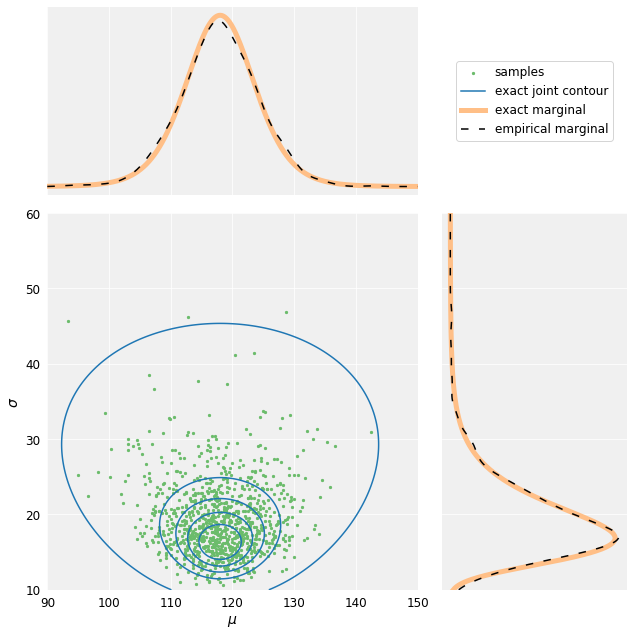

In [28]:
print('Joint and marginal posterior distributions')

# figure 생성
fig, axes = plt.subplots(
    2, 2,
    figsize=(9, 9),
    gridspec_kw=dict(
        width_ratios=[2, 1],
        height_ratios=[1, 2]
    )
)

# 결합밀도 plot
ax = axes[1, 0]

# 결합 사후분포의 샘플 plot
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))

# 정확한 사후분포의 등고선 plot
# c_level라는 선형간격 벡터(np.linspace) 이용해 그릴 등고선 레벨 결정 
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')

ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize='14')
ax.set_ylabel('$\sigma$', fontsize='14')

# mu의 주변부밀도함수 plot
ax = axes[0, 0]
# 정확한 값(exact)
ax.plot(
    t1,
    pm_mu,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# 앞선 kde추청을 통한 경험적 값(empirical)
ax.plot(
    t1,
    pk_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)

ax.set_xlim(tl1)
ax.set_yticks(())
ax.set_xticklabels(())

# sigma의 주변부 plot
ax = axes[1, 1]

# 정확한 값(exact)
exact_line, = ax.plot(
    pm_sigma,
    t2,
    color=plot_tools.lighten('C1'),
    linewidth=5
)

# 앞선 kde추청을 통한 경험적 값(empirical)
empirical_line, = ax.plot(
    pk_sigma,
    t2,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)

# 표 보정 (범위 값 설정, 마지막 axis 삭제, 리간드 따로 설정 등)
ax.set_ylim(tl2)
ax.set_xticks(())
ax.set_yticklabels(())

ax = axes[0, 1]
ax.axis('off')

ax.legend(
    (
        samps,
        plt.Line2D([], [], color='C0'),
        exact_line,
        empirical_line
    ),
    (
        'samples',
        'exact joint contour',
        'exact marginal',
        'empirical marginal'
    ),
    loc='center',
)

# 여백 설정
fig.tight_layout() 

Visualise factored sampling and the corresponding marginal and conditional densities.

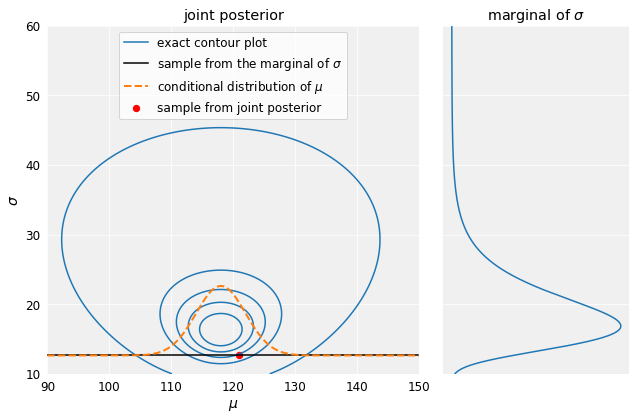

In [30]:
# figure 생성
fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 6),
    gridspec_kw=dict(width_ratios=[2, 1])
)

# 주변부밀도함수 plot
ax = axes[0]

# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')

# plot the first sample
line1, = ax.plot(tl1, [sigma[0], sigma[0]], 'k')
line2, = ax.plot(
    t1,
    sigma[0] + stats.norm.pdf(t1, my, np.sqrt(sigma2[0]/n))*100,
    color='C1',
    linestyle='dashed',
    linewidth=2
)
scat = ax.scatter(mu[0], sigma[0], 40, color='r')

ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_title('joint posterior')
ax.legend(
    (plt.Line2D([], [], color='C0'), line1, line2, scat),
    ('exact contour plot',
     'sample from the marginal of $\\sigma$',
     'conditional distribution of $\\mu$',
     'sample from joint posterior'),
    loc='upper center'
)

# sigma의 주변부밀도함수 plot
ax = axes[1]
ax.plot(pm_sigma, t2)

ax.set_ylim(tl2)
ax.set_title('marginal of $\sigma$')
ax.set_xticks(());
ax.set_yticklabels(())

fig.tight_layout()

정규분포 혼합 모형에서 평균에 대한 주변 분포를 시각화한 것.

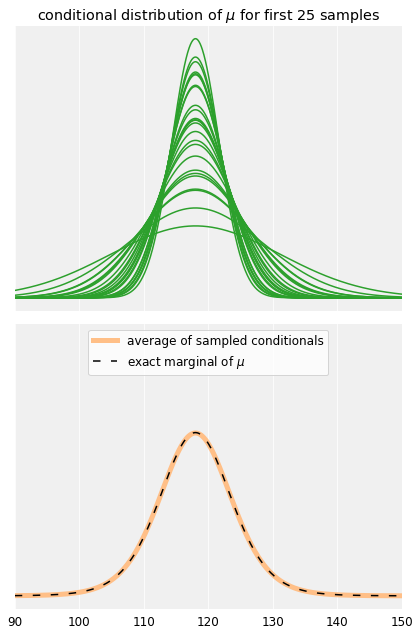

In [35]:
# 각 sample에 대한 조건부 pdf 계산
condpdfs = stats.norm.pdf(t1, my, np.sqrt(sigma2/n)[:,np.newaxis])

fig, axes = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

# 조건부 pdf 중 일부만 plot
ax = axes[0]
# ax.plot(t1, condpdfs[:25].T, 'C2', alpha=0.25)
ax.plot(t1, condpdfs[:25].T, 'C2') #, alpha=0.25)
ax.set_xlim(tl1)
ylims_from_0 = ax.set_ylim()  # set same y_lims to the next plot
ax.set_title('conditional distribution of $\\mu$ for first 25 samples')
ax.set_yticks(())

# 평균 plot
ax = axes[1]
ax.plot(
    t1,
    np.mean(condpdfs, axis=0),
    color=plot_tools.lighten('C1'),
    linewidth=5,
    label='average of sampled conditionals'
)
ax.plot(
    t1,
    pm_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5,
    label='exact marginal of $\\mu$'
)
ax.set_yticks(())
ax.set_xlim(tl1)
ax.set_ylim(ylims_from_0)
ax.legend(loc='upper center')

fig.tight_layout()

Visualise sampling from the posterior predictive distribution.

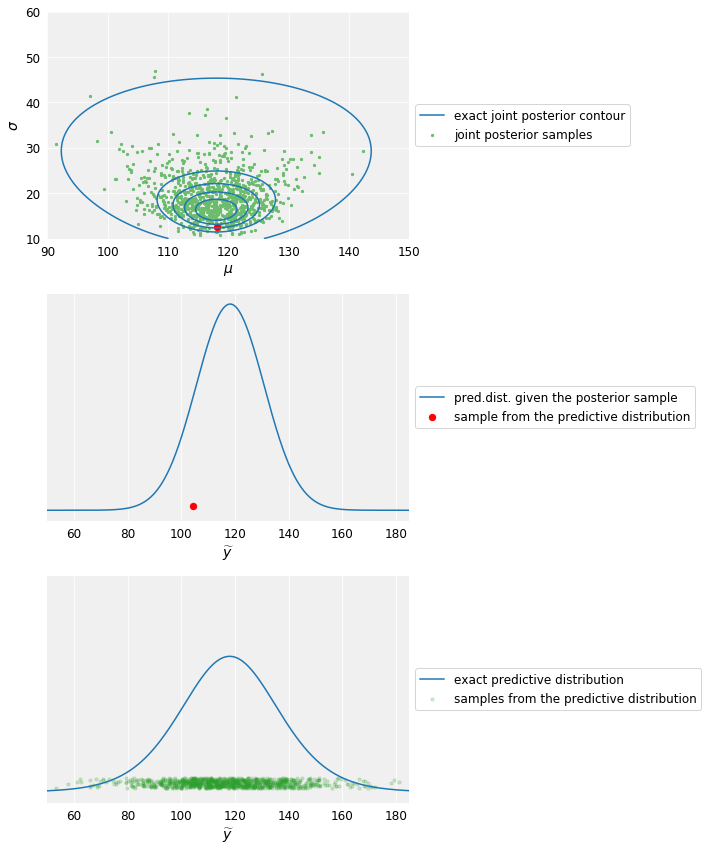

In [29]:
# 첫 sample에서 주어진 mu와 sigma를 바탕으로 예측분포 pdf 계산
ynewdists = stats.norm.pdf(xynew, mu[0], sigma[0])

# figure 생성
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# plot the joint distribution

ax = axes[0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.legend(
    (plt.Line2D([], [], color='C0'), samps),
    ('exact joint posterior contour', 'joint posterior samples'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
# highlight the first sample
ax.scatter(mu[0], sigma[0], 40, 'r')

# 첫번째 ynew를 그래프 상에 나타낸다.
ax = axes[1]

# 각 sample과 분포를 그림
line1, = ax.plot(xynew, ynewdists)
ax1_hs = ax.scatter(ynew[0], 0.02*np.max(ynewdists), 40, 'r')

ylims_from_1 = ax.set_ylim()
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(
    (line1, ax1_hs),
    ('pred.dist. given the posterior sample',
    'sample from the predictive distribution'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

# 모든 ynews를 그래프 상에 나타낸다.
ax = axes[2]
ax.scatter(
    ynew,
    (0.02 + 0.05*rng.rand(*ynew.shape))*np.max(ynewdists), ###
    10,
    color='C2',
    alpha=0.2,
    label='samples from the predictive distribution'
)
ax.plot(
    xynew,
    p_new,
    linewidth=1.5,
    label='exact predictive distribution'
)
ax.set_ylim(ylims_from_1)
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()